In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../CCN-proxy-modeling/data/full_data.csv', parse_dates=['date'])

stations = ['SGP', 'EGB', 'AMA', 'SAO', 'HRW', 'VIE', 'BSL', 'WAL', 'POV', 'MLP', 'ABZ',
            'ABZ', 'NEU', 'VHL', 'KCE', 'ASP', 'KPZ', 'PRL', 'HYY', 'HEL', 'VAR', 'BOT',
            'MAR', 'AMM', 'HAD', 'UAE', 'DEL', 'MUK', 'ZOT', 'BEI', 'NAN']

# filter
data = data[data.station.isin(stations)]
data = data[data.n100 >= 1]

data['weight'] = compute_sample_weight(class_weight='balanced', y=data.station)

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude']

log_transform = ['n100'] + aerosols + gases + ['crwc']

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    data[v] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))    
    
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude,n100,aermr01,aermr02,...,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed,weight
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,50.57,12.99,7.903997,-25.721079,-21.273927,...,-18.156078,-17.697916,-18.856889,266.65186,268.37625,-24.294392,306.51462,87.716470,1.228889,1.090593
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,50.57,12.99,7.819707,-26.190396,-21.744714,...,-18.022533,-17.632291,-18.761336,265.71246,267.83536,-24.294392,142.03300,85.013445,0.962691,1.090593
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,50.57,12.99,8.156002,-26.362989,-21.924610,...,-17.223582,-17.785600,-18.708921,268.29993,269.69257,-24.294392,152.80160,90.074210,0.785850,1.090593
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,50.57,12.99,7.998843,-25.471693,-21.036951,...,-19.236020,-17.969860,-19.128033,267.07495,269.08804,-24.294392,461.47455,85.875228,1.748744,1.090593
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,50.57,12.99,7.901919,-24.965992,-20.533617,...,-20.702253,-18.124264,-19.070916,263.61273,267.95770,-24.294392,610.29910,71.525093,2.068425,1.090593


In [3]:
def xgboost(X, y, params, sample_weight, tune=False, gpu=True):
    if gpu:
        model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **params)
    else:
        model = xgb.XGBRegressor(**params)
    if tune:
        model = GridSearchCV(estimator=model, param_grid=params)
    model.fit(X_train, y_train, sample_weight=sample_weight)
    return model

In [4]:
def linear_regression(X, y, sample_weight):
    model = LinearRegression()
    model = model.fit(X_train, y_train, sample_weight=sample_weight)
    return model

In [5]:
def print_equation(model, predictors, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'n100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + f'{predictors[i]}_log' if predictors[i] in log_transform else predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

In [6]:
def evaluate(y_pred, y):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    # Calculate number of points between 1:2 and 2:1 lines
    mask_between_lines = (y > 0.5 * y_pred) & (y < 2 * y_pred)
    num_points_between_lines = np.sum(mask_between_lines)
    fraction = num_points_between_lines / len(y)
    
    return rmse, r2, fraction

In [7]:
def plot_results(y_pred, y):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    
    # Plot preds v true
    ax.scatter(y_pred, y, s=5)
    
    # Add 1:1 line
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')

    # Add 1:2 line
    ax.plot([y.min(), y.max()], [y.min()/2, y.max()/2], color='gray', linestyle='--',)

    # Add 2:1 line
    ax.plot([y.min(), y.max()], [y.min()*2, y.max()*2], color='gray', linestyle='--',)

    # Set axis labels and scale
    ax.set_xlabel('Predicted N100 ($\mathrm{cm}^{-3}$)')
    ax.set_ylabel('Observed N100 ($\mathrm{cm}^{-3}$)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim([0.4, 1.9e5])
    ax.set_ylim([0.4, 1.9e5])
    
    plt.show()

In [8]:
features = gases + met + aerosols
X, y = data[features + ['weight']], data.n100
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
train_weight = X_train.pop('weight')
test_weight = X_test.pop('weight')

In [9]:
regressor = linear_regression(X_train, y_train, train_weight)

In [10]:
print_equation(regressor, features)

Model equation:
n100_log = 0.322*co_log - 0.008*c5h8_log + 0.014*c10h16_log + 0.099*nh3_log + 0.021*no_log + 0.006*no2_log + 0.106*so2_log - 0.042d2m + 0.053t2m - 0.001blh + 0.016rh + 0.094wind_speed - 0.029*crwc_log - 0.074*aermr01_log + 0.052*aermr02_log + 0.007*aermr03_log - 0.016*aermr04_log + 0.006*aermr05_log - 0.008*aermr06_log - 0.312*aermr07_log + 0.185*aermr08_log + 0.387*aermr09_log - 0.172*aermr10_log + 0.207*aermr11_log + 17.627



RMSE: 1002.94, R2: 0.60, Fraction within factor two: 0.78


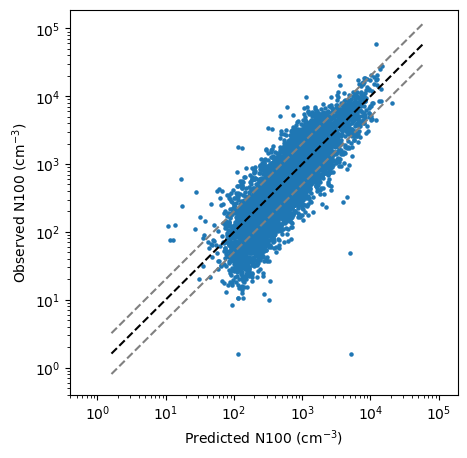

In [11]:
y_pred = regressor.predict(X_test)
rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
print(f'RMSE: {rmse:.2f}, R2: {r2:.2f}, Fraction within factor two: {fraction:.2f}')
plot_results(np.exp(y_pred), np.exp(y_test))

In [12]:
params = {'n_estimators': [100], 'reg_lambda': [3], 'learning_rate': [0.1], 'max_depth': [10]}

In [13]:
tuning = xgboost(X_train, y_train, params, train_weight, tune=True)

In [14]:
params = tuning.best_params_
print(params)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_lambda': 3}


In [15]:
regressor = tuning.best_estimator_

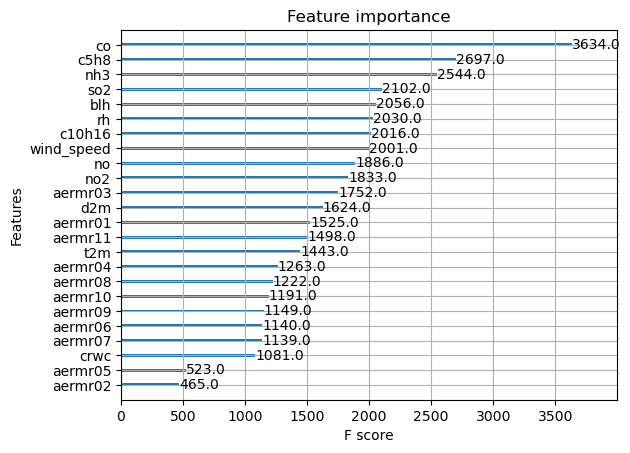

In [16]:
xgb.plot_importance(regressor)
plt.show()

RMSE: 799.36, R2: 0.75, Fraction within factor two: 0.91


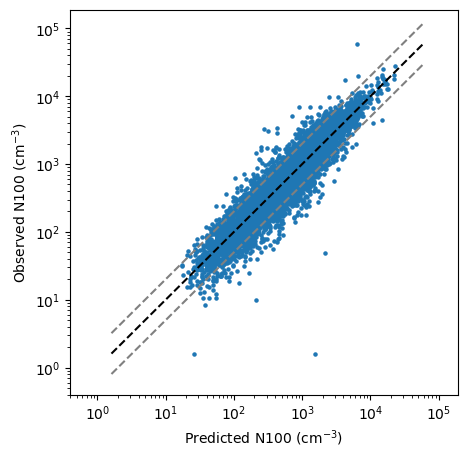

In [17]:
y_pred = regressor.predict(X_test)
rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
print(f'RMSE: {rmse:.2f}, R2: {r2:.2f}, Fraction within factor two: {fraction:.2f}')
plot_results(np.exp(y_pred), np.exp(y_test))

In [18]:
lr_results = {}
xgboost_results = {}
for station in stations:
    # Select data
    data_train = data[data.station != station]
    data_test = data[data.station == station]
    X_train, y_train = data_train[features], data_train.n100
    X_test, y_test = data_test[features], data_test.n100
    
    # Train linear regression
    regressor = linear_regression(X_train, y_train, sample_weight=data_train.weight)
    y_pred = regressor.predict(X_test)
    rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
    lr_results[station] = {'rmse': rmse, 'r2': r2, 'fraction': fraction}
    
    # Train XGBoost
    regressor = xgboost(X_train, y_train, params, sample_weight=data_train.weight)
    y_pred = regressor.predict(X_test)
    rmse, r2, fraction = evaluate(np.exp(y_pred), np.exp(y_test))
    xgboost_results[station] = {'rmse': rmse, 'r2': r2, 'fraction': fraction}

In [27]:
def plot_bar_comparison(lr_results, xgboost_results, metric):
    lr_keys = list(lr_results.keys())

    # Get the fraction values for each dictionary, in the same order as the keys
    lr_fractions = [lr_results[k][metric] for k in lr_keys]
    xgboost_fractions = [xgboost_results[k][metric] for k in lr_keys]
    
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot()

    width = 0.3 # the width of the bars
    x = range(len(lr_keys)) # the x locations for the bars

    # Plot the bars for Linear Regression
    avg = np.mean(lr_fractions)
    std = np.std(lr_fractions)
    rects1 = ax.bar([i - width/2 for i in x], lr_fractions, width, label=f'Linear Regression, avg: {avg:.2f} ± {std:.2f}')

    # Plot the bars for XGBoost
    avg = np.mean(xgboost_fractions)
    std = np.std(xgboost_fractions)
    rects2 = ax.bar([i + width/2 for i in x], xgboost_fractions, width, label=f'XGBoost, avg: {avg:.2f} ± {std:.2f}')

    # Add some labels, etc.
    ax.set_ylabel('Fraction of predictions within 1:2 and 2:1', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(lr_keys)
    ax.tick_params(labelsize=13)
    ax.set_ylim([0, 1])
    ax.set_xlim([-1, len(lr_keys)])
    ax.legend(prop={'size': 15})
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
    plt.show()

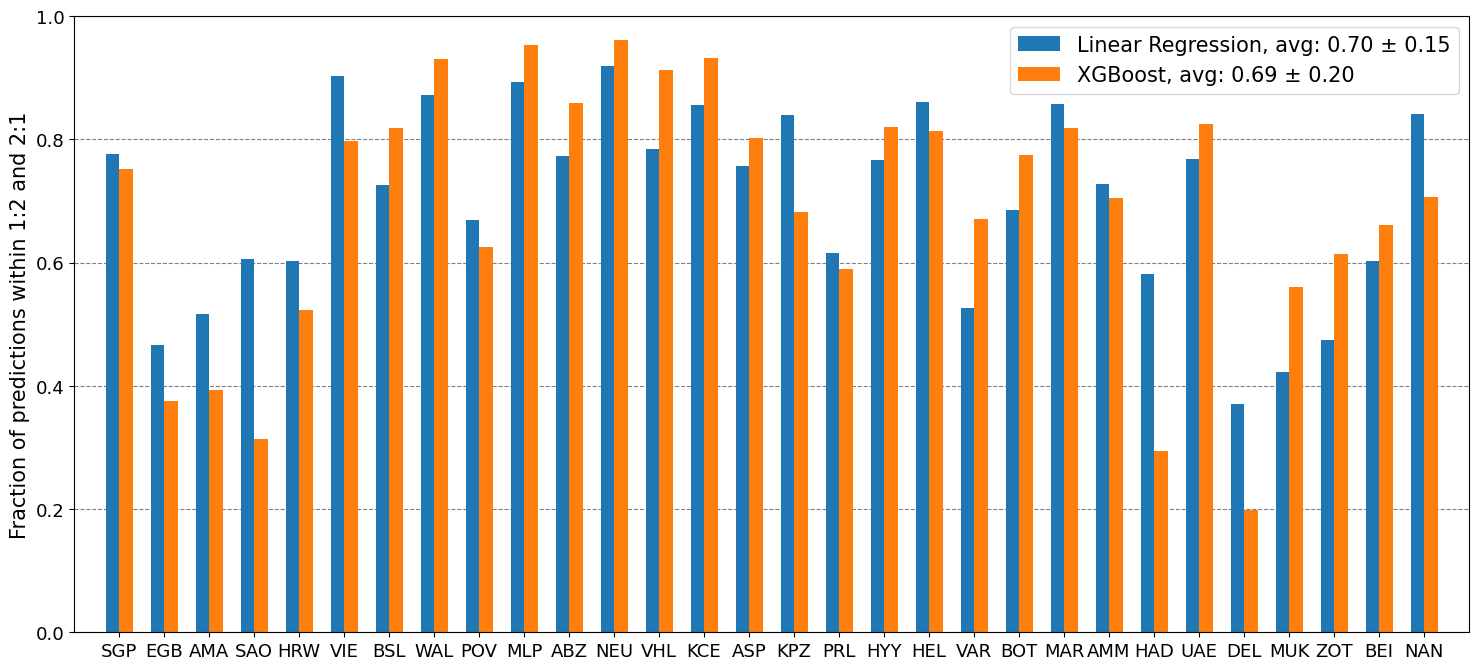

In [28]:
plot_bar_comparison(lr_results, xgboost_results, 'fraction')